# Portfolio Currator - Project 1 

Welcome to my first project! this project serves to collect data, analyze the data, and create visualizations to support our conclusions and analysis. After getting the data, we will move on to using the data to offer a financial product, in the form of a portfolio optimized to meet medical insurance charges by a certain date. 

# Part 1. Importing Libraries and Dependencies

In [339]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from modules.MCForecastTools import MCSimulation
from io import BytesIO
import numpy as np
import numba as nb
import holoviews as hv
import panel as pn
import hvplot.pandas
from scipy.optimize import minimize
%matplotlib inline

# Part 2. Getting the MD Insurance Data
Part one of the project is largely made up of pulling in the data, cleaing the data, and visualizing it for use later in the portfolio currator.
The primary goal of the Data creation segment of the project will be to have a dataframe with the expected percent change in medical costs, in relation to age.


#### Step 1. Load .csv file and create DataFrame :

In [340]:
# Import the data by reading in the CSV file 
# Review the first 5 rows of the DataFrame
medical_costs_df = pd.read_csv(
    Path("./Resources/Medical_Cost.csv"),
)
medical_costs_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [341]:
# Creating a Dataframe holding grouped based on charges, and age.

md_cost_age_df = (
 medical_costs_df[["charges", "age"]]
 .groupby("age")
 .mean()
 .sort_values("age")
)
# Reviewing dataframe
print(" 1. Review of MD Data :")
display(md_cost_age_df.head())


 1. Review of MD Data :


,charges
age,
18,7086.217556
19,9747.909335
20,10159.697736
21,4730.464330
22,10012.932802


#### Step 2. Review Data and Dataframe :

In [342]:
# Creating summary statistics of the data.
print("2. Summary Statistics of MD Data :")
print("")

# Review the summary of the Medical Insurance data, before applying .pct_change(). 
print(" MD Insurance Charges - Data Summary :")
display(md_cost_age_df.describe())

md_cost_age_df_change = md_cost_age_df['charges'].pct_change()

# Review the MD cost 'pct_change' data frame.
print(" Rate of Change of MD Insurance Charges - Data Summary :")
print("")
display(md_cost_age_df_change.describe())

2. Summary Statistics of MD Data :

 MD Insurance Charges - Data Summary :


,charges
count,47.000000
mean,13720.545008
std,4322.618833
min,4730.464330
25%,10313.569650
50%,12719.110358
75%,16305.865369
max,23275.530837


 Rate of Change of MD Insurance Charges - Data Summary :



count    46.000000
mean      0.070581
std       0.319671
min      -0.550346
25%      -0.131727
50%       0.001639
75%       0.228023
max       1.116691
Name: charges, dtype: float64

---

# Part 2.5 - Getting the Stock Data


We will be using the Alpaca API to pull in stock data, which we can later analyze to find the 'top ten' stocks in the list of '50 S&P500 top-performing stocks'. 

 - **Why I decided to take the S&P 500's top 50 most weighted stocks as our data sample**:
 

   1. The Alpaca API is a free-to-use online public API, which holds a large database of stock, and crypto data. We will, as mentioned, pull in 50 of the most highly weighted stocks in the S&P 500, which is generally regarded to have companies of such a size that any major downturns in the portfolio will likely correlate with downturns in the overall economy. More specifically, the S&P 500 is very much linked to U.S. economic prosperity. 
   
   2. If the U.S. economy continues to grow and stay the dominant player in our global economy, U.S. corporations andtheir stocks should generally produce stable returns. The U.S. has a strong currency used throughout the world, and a strong regulatory and business framework. 
    
   3. These are among the most important reasons for my picking the S&P 500's 50 most weighted stocks to begin our analysis-- this was not a quantitative decision, but I believe my explanation has adequately described why a focus on U.S. stocks is  
    
   4. U.S. economic growth has outpaced Europe, and the Chinese and other emerging markets. Though investment in emerging markets can prove lucrative, regulatory issues in many emerging markets (bureacracy in the Indian Business Environment and Government control in the Chinese economy, as well as inneficient monteary policies in many South American and African markets). Europe has ben outpaces by the U.S. for many years, and have seen themselves become less productive than Americans on-average. The U.S. has a well-developed regulatory framework with the SEC, IRA, and other related instutions overseeing the American financial markets. 

#### Step 1. Load .env files :

In [343]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [344]:
# Set Alpaca API key and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
type(alpaca_secret_key )

# Create the Alpaca REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

---

#### Step 2. Pull in stock data from Alpaca:

In [345]:
# Set the ticker information
tickers = [
    "BRK.B",
    "MSFT",
    "AMZN",
    "GOOGL",
    "MS",
    "NVDA",
    "TSLA",
    "GOOG",
    "XOM",
    "UNH",
    "JPM",
    "JNJ",
    "META",
    "V",
    "HD",
    "PG",
    "MA",
    "CVX",
    "MRK",
    "ABBV",
    "LLY",
    "BAC",
    "AVGO",
    "PEP",
    "PFE",
    "KO",
    "COST",
    "TMO",
    "CSCO",
    "WMT",
    "MCD",
    "DIS",
    "ABT",
    "WFC",
    "ACN",
    "CMCSA",
    "ADBE",
    "CRM",
    "DHR",
    "VZ",
    "TXN",
    "LIN",
    "NKE",
    "NFLX",
    "PM",
    "BMY",
    "NEE",
    "RTX",
    "QCOM",
    "T"
    ]
# Set timeframe to '1Day'
timeframe = "1Day"

# Set start and end datetimes between now and 3 years ago
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Get price data for the S&P 500 top-50 stocks.
prices_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
BRK = prices_df[prices_df['symbol']=='BRK.B'].drop('symbol', axis=1)
MSFT = prices_df[prices_df['symbol']=='MSFT'].drop('symbol', axis=1)
AMZN = prices_df[prices_df['symbol']=='AMZN'].drop('symbol', axis=1)
GOOGL = prices_df[prices_df['symbol']=='GOOGL'].drop('symbol', axis=1)
MS = prices_df[prices_df['symbol']=='MS'].drop('symbol', axis=1)
NVDA = prices_df[prices_df['symbol']=='NVDA'].drop('symbol', axis=1)
TSLA = prices_df[prices_df['symbol']=='TSLA'].drop('symbol', axis=1)
GOOG = prices_df[prices_df['symbol']=='GOOG'].drop('symbol', axis=1)
XOM = prices_df[prices_df['symbol']=='XOM'].drop('symbol', axis=1)
UNH = prices_df[prices_df['symbol']=='UNH'].drop('symbol', axis=1)
JPM = prices_df[prices_df['symbol']=='JPM'].drop('symbol', axis=1)
JNJ = prices_df[prices_df['symbol']=='JNJ'].drop('symbol', axis=1)
META = prices_df[prices_df['symbol']=='META'].drop('symbol', axis=1)
V = prices_df[prices_df['symbol']=='V'].drop('symbol', axis=1)
HD = prices_df[prices_df['symbol']=='HD'].drop('symbol', axis=1)
PG = prices_df[prices_df['symbol']=='PG'].drop('symbol', axis=1)
MA = prices_df[prices_df['symbol']=='MA'].drop('symbol', axis=1)
CVX = prices_df[prices_df['symbol']=='CVX'].drop('symbol', axis=1)
MRK = prices_df[prices_df['symbol']=='MRK'].drop('symbol', axis=1)
ABBV = prices_df[prices_df['symbol']=='ABBV'].drop('symbol', axis=1)
LLY = prices_df[prices_df['symbol']=='LLY'].drop('symbol', axis=1)
BAC = prices_df[prices_df['symbol']=='BAC'].drop('symbol', axis=1)
AVGO = prices_df[prices_df['symbol']=='AVGO'].drop('symbol', axis=1)
PEP = prices_df[prices_df['symbol']=='PEP'].drop('symbol', axis=1)
PFE = prices_df[prices_df['symbol']=='PFE'].drop('symbol', axis=1)
KO = prices_df[prices_df['symbol']=='KO'].drop('symbol', axis=1)
COST = prices_df[prices_df['symbol']=='COST'].drop('symbol', axis=1)
TMO = prices_df[prices_df['symbol']=='TMO'].drop('symbol', axis=1)
CSCO = prices_df[prices_df['symbol']=='CSCO'].drop('symbol', axis=1)
WMT = prices_df[prices_df['symbol']=='WMT'].drop('symbol', axis=1)
MCD = prices_df[prices_df['symbol']=='MCD'].drop('symbol', axis=1)
DIS = prices_df[prices_df['symbol']=='DIS'].drop('symbol', axis=1)
ABT = prices_df[prices_df['symbol']=='ABT'].drop('symbol', axis=1)
WFC = prices_df[prices_df['symbol']=='WFC'].drop('symbol', axis=1)
ACN = prices_df[prices_df['symbol']=='ACN'].drop('symbol', axis=1)
CMCSA = prices_df[prices_df['symbol']=='CMCSA'].drop('symbol', axis=1)
ADBE = prices_df[prices_df['symbol']=='ADBE'].drop('symbol', axis=1)
CRM = prices_df[prices_df['symbol']=='CRM'].drop('symbol', axis=1)
DHR = prices_df[prices_df['symbol']=='DHR'].drop('symbol', axis=1)
VZ = prices_df[prices_df['symbol']=='VZ'].drop('symbol', axis=1)
TXN = prices_df[prices_df['symbol']=='TXN'].drop('symbol', axis=1)
LIN = prices_df[prices_df['symbol']=='LIN'].drop('symbol', axis=1)
NKE = prices_df[prices_df['symbol']=='NKE'].drop('symbol', axis=1)
NFLX = prices_df[prices_df['symbol']=='NFLX'].drop('symbol', axis=1)
PM = prices_df[prices_df['symbol']=='PM'].drop('symbol', axis=1)
BMY = prices_df[prices_df['symbol']=='BMY'].drop('symbol', axis=1)
NEE = prices_df[prices_df['symbol']=='NEE'].drop('symbol', axis=1)
RTX = prices_df[prices_df['symbol']=='RTX'].drop('symbol', axis=1)
QCOM = prices_df[prices_df['symbol']=='QCOM'].drop('symbol', axis=1)
T = prices_df[prices_df['symbol']=='T'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
prices_df = pd.concat([
    BRK,
    MSFT,
    AMZN,
    GOOGL,
    MS,
    NVDA,
    TSLA,
    GOOG,
    XOM,
    UNH,
    JPM,
    JNJ,
    META,
    V,
    HD,
    PG,
    MA,
    CVX,
    MRK,
    ABBV,
    LLY,
    BAC,
    AVGO,
    PEP,
    PFE,
    KO,
    COST,
    TMO,
    CSCO,
    WMT,
    MCD,
    DIS,
    ABT,
    WFC,
    ACN,
    CMCSA,
    ADBE,
    CRM,
    DHR,
    VZ,
    TXN,
    LIN,
    NKE,
    NFLX,
    PM,
    BMY,
    NEE,
    RTX,
    QCOM,
    T], axis=1, keys=[
    "BRK.B",
    "MSFT",
    "AMZN",
    "GOOGL",
    "MS",
    "NVDA",
    "TSLA",
    "GOOG",
    "XOM",
    "UNH",
    "JPM",
    "JNJ",
    "META",
    "V",
    "HD",
    "PG",
    "MA",
    "CVX",
    "MRK",
    "ABBV",
    "LLY",
    "BAC",
    "AVGO",
    "PEP",
    "PFE",
    "KO",
    "COST",
    "TMO",
    "CSCO",
    "WMT",
    "MCD",
    "DIS",
    "ABT",
    "WFC",
    "ACN",
    "CMCSA",
    "ADBE",
    "CRM",
    "DHR",
    "VZ",
    "TXN",
    "LIN",
    "NKE",
    "NFLX",
    "PM",
    "BMY",
    "NEE",
    "RTX",
    "QCOM",
    "T"])


In [346]:
# Review the first 5 rows of the DataFrame
prices_df['AMZN']

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2017-05-01 04:00:00+00:00,927.800,954.40,927.8000,948.23,5466544,76807,946.125930
2017-05-02 04:00:00+00:00,946.645,950.10,941.4130,946.94,3848855,57885,944.623613
2017-05-03 04:00:00+00:00,946.000,946.00,935.9000,941.03,3584282,54142,939.693811
2017-05-04 04:00:00+00:00,944.750,945.00,934.2150,937.53,2418381,38163,937.595217
2017-05-05 04:00:00+00:00,940.520,940.79,930.3000,934.15,2866397,43820,933.113819
...,...,...,...,...,...,...,...
2020-04-27 04:00:00+00:00,2443.200,2444.88,2363.0000,2376.00,5645665,204763,2401.123184
2020-04-28 04:00:00+00:00,2372.100,2373.50,2306.0000,2314.08,5269448,203378,2330.333158
2020-04-29 04:00:00+00:00,2330.010,2391.89,2310.0000,2372.71,4591593,175822,2361.710192


---

# Part 3. Data Cleaning : Cleaning and Seperating the MD Insurance Data.
The acquired data needs some working with, as there is a high standard deviation in the pct_change() data of the dataset, and the correlation is not strong enough between increases in MD insurance costs. To solve this issue, I will find the average year-to-year increase from the entire dataset, instead of first focusing on age, and see if this changes the data outcome! 

---

#### Step 1. Seperate the MD insurance data

In [347]:
# Use 'group.by' to seperate the data, 
# as we only need the 'charges', 'age', and 'age' data for our project.
md_cost_age_df_1 = (
 medical_costs_df[["charges", "age"]]
 .groupby("age")
 .mean()
 .pct_change()
 .sort_values("age")
)


#### Step 2. Analyze the MD Insurance Data :

In [348]:

md_cost_age_df_median = md_cost_age_df_1.median()
md_cost_age_df_mean = md_cost_age_df_1.mean()


In [349]:
display(md_cost_age_df_1.describe())
display(print(f" the expected median pct_change in MD insurance charges will likely be close to: +{float(md_cost_age_df_median.tail(1))* 100}%"))
display(print(f" the expected mean (average) pct_change in MD insurance charges will likely be close to: +{float(md_cost_age_df_mean.tail(1)* 100)}%"))
print(f" Based on the data, an average annual pct_change() in total medical insurance costs, between the ages of 18 and 64 should end up at a roughly +{float(md_cost_age_df_mean.tail(1)* 100)}% annually")

print("Based on these results, the user should definetely look to invest sooner, so as not to miss out on the time-value of money. But they are also shown that even with expected charges, there remains uncertainty-- the ROC for MD insurance costs has a median value far less than the average, meaning there is a discrepency between the changes as we age, and between different individuals.")


,charges
count,46.000000
mean,0.070581
std,0.319671
min,-0.550346
25%,-0.131727
50%,0.001639
75%,0.228023
max,1.116691


 the expected median pct_change in MD insurance charges will likely be close to: +0.16391617745324938%


None

 the expected mean (average) pct_change in MD insurance charges will likely be close to: +7.05805500745121%


None

 Based on the data, an average annual pct_change() in total medical insurance costs, between the ages of 18 and 64 should end up at a roughly +7.05805500745121% annually
Based on these results, the user should definetely look to invest sooner, so as not to miss out on the time-value of money. But they are also shown that even with expected charges, there remains uncertainty-- the ROC for MD insurance costs has a median value far less than the average, meaning there is a discrepency between the changes as we age, and between different individuals.


# Part 3.5. Data Cleaning - Cleaning and Analyzing the API Data :

#### Step 1. Create a Closing Prices DataFrame for the stocks

In [350]:
# Create and fill an empty closing_prices_df for the stock data. 
closing_prices_df = pd.DataFrame()

# Using a for loop, for every ticker in the tickers list, 
# Select the close price for each ticker in the prices_df Dataframe
# That will be set equal to closing_prices_df for the same ticker value
for ticker in tickers:
    closing_prices_df[ticker] = prices_df[ticker]["close"]

# For the new closing_prices_df DataFrame, keep only the date component
closing_prices_df.index = closing_prices_df.index.date

#Remove missing values
closing_prices_df = closing_prices_df.dropna()


In [351]:
# Review the closing_prices_df DataFrame
display(closing_prices_df.head())
display(closing_prices_df.describe())

,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
2018-10-31,205.28,106.81,1598.01,1090.58,45.66,210.83,337.32,1076.77,79.68,261.35,...,92.83,165.47,75.04,301.78,88.07,50.54,172.50,124.21,62.89,30.68
2018-11-01,205.86,105.92,1665.53,1085.98,45.89,218.11,344.28,1070.00,80.67,260.93,...,97.60,162.00,76.79,317.38,88.35,52.13,170.47,127.58,63.71,30.49
2018-11-02,206.57,106.16,1665.53,1071.49,45.95,214.92,346.41,1057.79,81.95,261.01,...,95.06,159.84,76.58,309.10,88.75,50.69,168.15,127.43,63.33,30.52
2018-11-05,216.24,107.51,1627.80,1055.73,45.82,211.77,341.40,1040.09,81.64,261.01,...,95.66,161.99,77.53,315.44,89.55,52.03,170.71,127.25,63.47,30.63
2018-11-06,218.51,107.72,1642.81,1069.57,45.72,211.06,341.06,1055.81,81.99,263.54,...,97.14,165.53,76.57,310.84,88.77,51.35,171.46,127.94,63.63,30.96


,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,...,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,207.594509,135.602418,1817.890286,1206.193538,44.157613,192.276833,361.351631,1203.749122,69.160318,256.702122,...,113.799955,185.447374,86.313873,331.977639,81.125305,52.737560,213.241326,127.688886,71.981326,33.642069
std,12.183872,22.400335,174.213182,119.849766,4.971098,43.849438,167.086088,122.572160,11.651756,22.024953,...,11.636354,18.518924,8.334405,40.678780,6.307076,6.487624,28.469703,21.051552,12.656961,3.490929
min,162.130000,94.130000,1343.960000,984.670000,27.810000,127.040000,178.970000,976.220000,31.450000,194.860000,...,87.829000,148.130000,62.800000,233.880000,59.980000,42.770000,168.080000,49.930000,49.400000,26.770000
25%,201.020000,117.050000,1720.260000,1113.200000,41.370000,156.780000,243.490000,1110.750000,68.190000,242.230000,...,105.710000,169.860000,81.990000,295.760000,76.860000,47.560000,189.310000,124.020000,57.760000,30.620000
50%,206.690000,136.580000,1800.800000,1190.130000,43.490000,179.850000,310.120000,1188.010000,71.490000,251.400000,...,114.930000,187.130000,85.640000,338.620000,83.050000,50.780000,209.730000,130.790000,74.680000,32.390000
75%,216.580000,150.580000,1898.530000,1272.250000,46.830000,217.270000,376.790000,1275.880000,76.560000,272.450000,...,123.570000,201.820000,90.930000,362.440000,85.950000,57.410000,233.820000,139.590000,82.080000,37.430000
max,230.200000,188.700000,2474.000000,1524.870000,57.510000,314.700000,917.420000,1526.690000,83.380000,305.310000,...,134.250000,223.550000,104.580000,439.170000,91.910000,67.430000,282.220000,156.830000,95.910000,39.630000


#### Step 2. Create a Daily Returns DataFrame for the stocks

In [352]:
# Compute daily returns of the closing_prices_df DataFrame using the pct_change function 
# Be sure to drop the first row of NaN values
daily_returns_df = closing_prices_df.pct_change().dropna()

#Remove missing values
daily_returns_df = daily_returns_df.dropna()


In [353]:
# Review the resulting daily_returns_df DataFrame
display(daily_returns_df.head())
display(daily_returns_df.describe())

,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
2018-11-01,0.002825,-0.008333,0.042253,-0.004218,0.005037,0.034530,0.020633,-0.006287,0.012425,-0.001607,...,0.051384,-0.020971,0.023321,0.051693,0.003179,0.031460,-0.011768,0.027131,0.013039,-0.006193
2018-11-02,0.003449,0.002266,0.000000,-0.013343,0.001307,-0.014626,0.006187,-0.011411,0.015867,0.000307,...,-0.026025,-0.013333,-0.002735,-0.026089,0.004527,-0.027623,-0.013609,-0.001176,-0.005965,0.000984
2018-11-05,0.046812,0.012717,-0.022653,-0.014708,-0.002829,-0.014657,-0.014463,-0.016733,-0.003783,0.000000,...,0.006312,0.013451,0.012405,0.020511,0.009014,0.026435,0.015225,-0.001413,0.002211,0.003604
2018-11-06,0.010498,0.001953,0.009221,0.013109,-0.002182,-0.003353,-0.000996,0.015114,0.004287,0.009693,...,0.015471,0.021853,-0.012382,-0.014583,-0.008710,-0.013069,0.004393,0.005422,0.002521,0.010774
2018-11-07,0.012494,0.039361,0.068590,0.036155,0.019466,0.012935,0.020817,0.035594,0.012684,0.042081,...,0.000618,0.007974,0.018284,0.053597,0.003380,0.031938,0.012131,0.020400,-0.006601,0.004522


,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,...,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,-0.000151,0.001567,0.001181,0.000730,-0.000063,0.001430,0.002904,0.000772,-0.001379,0.000568,...,0.000755,0.000429,0.000591,0.001205,-0.000246,0.000644,0.000946,-0.001212,0.000923,0.000103
std,0.017852,0.022815,0.021426,0.021332,0.028349,0.035717,0.043724,0.021436,0.022412,0.026100,...,0.024975,0.020055,0.022113,0.026699,0.021907,0.018593,0.020734,0.033959,0.029664,0.018518
min,-0.095921,-0.147464,-0.079770,-0.116342,-0.156000,-0.187559,-0.185778,-0.111008,-0.122248,-0.172769,...,-0.118257,-0.102833,-0.116301,-0.111375,-0.124528,-0.139424,-0.134171,-0.419486,-0.149453,-0.086677
25%,-0.006407,-0.007743,-0.008356,-0.006939,-0.010885,-0.015614,-0.013863,-0.006692,-0.009536,-0.009513,...,-0.011014,-0.008610,-0.008455,-0.013664,-0.008173,-0.008210,-0.005590,-0.007235,-0.011746,-0.006057
50%,0.000364,0.001379,0.001189,0.000809,0.000419,0.002506,0.002538,0.000797,-0.001287,0.000374,...,0.000693,0.001287,0.000670,0.000050,0.001111,0.000385,0.001512,0.001057,0.000484,0.001346
75%,0.007134,0.010381,0.010199,0.009468,0.010800,0.018271,0.020661,0.009945,0.008804,0.009698,...,0.013042,0.009404,0.010589,0.016359,0.008809,0.010503,0.007433,0.009007,0.013679,0.007589
max,0.116099,0.142268,0.094452,0.096202,0.197700,0.171564,0.198949,0.104485,0.126868,0.127989,...,0.135294,0.116947,0.151752,0.097235,0.082171,0.061207,0.136904,0.157572,0.232074,0.079211


In [354]:
# Calculate the cumulative returns using the 'cumprod()' function:
cumulative_returns_df = (1 + daily_returns_df).cumprod()

# Review the Dataframe :
print(" Cumulative Returns DataFrame" )
print("")
cumulative_returns_df.head()


 Cumulative Returns DataFrame



,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
2018-11-01,1.002825,0.991667,1.042253,0.995782,1.005037,1.034530,1.020633,0.993713,1.012425,0.998393,...,1.051384,0.979029,1.023321,1.051693,1.003179,1.031460,0.988232,1.027131,1.013039,0.993807
2018-11-02,1.006284,0.993914,1.042253,0.982496,1.006351,1.019400,1.026948,0.982373,1.028489,0.998699,...,1.024022,0.965976,1.020522,1.024256,1.007721,1.002968,0.974783,1.025924,1.006996,0.994785
2018-11-05,1.053390,1.006554,1.018642,0.968045,1.003504,1.004459,1.012095,0.965935,1.024598,0.998699,...,1.030486,0.978969,1.033182,1.045265,1.016805,1.029482,0.989623,1.024475,1.009222,0.998370
2018-11-06,1.064449,1.008520,1.028035,0.980735,1.001314,1.001091,1.011087,0.980534,1.028991,1.008380,...,1.046429,1.000363,1.020389,1.030022,1.007948,1.016027,0.993971,1.030030,1.011767,1.009126
2018-11-07,1.077747,1.048216,1.098548,1.016193,1.020806,1.014040,1.032136,1.015435,1.042043,1.050813,...,1.047075,1.008340,1.039046,1.085228,1.011355,1.048476,1.006029,1.051043,1.005088,1.013690


In [355]:
# call the Pandas 'std' function on the 'daily_returns' DataFrame
standard_deviation_df = daily_returns_df.std()

# display results
standard_deviation_df.head()

BRK.B    0.017852
MSFT     0.022815
AMZN     0.021426
GOOGL    0.021332
MS       0.028349
dtype: float64

# Part 4. Visualizing the MD Insurance Data :
Visualization and descriptions of the Data help us understand the data we are working with, and review the data for any faults/drawbacks. Generally, the larger the data-set, and the more data that is used, the more accurate the data will be! By using python tools, and visualization plots, we can infer whether data needs to be cleaned, may have innacuracies, or won't aid us in achieving our desired outcome. 



#### Step 1. Review the MD Insurance Data Summary : 

In [356]:
# Clean data, drop missing values using .dropna() :

md_cost_age_df_median.dropna()
md_cost_age_df_mean.dropna()

charges    0.070581
dtype: float64

In [357]:
# Using describe and print statements - 
display(md_cost_age_df_1.describe())

print("")
display(print(f" The expected median pct_change in MD insurance charges will likely be close to: +{float(md_cost_age_df_median.tail(1))* 100}%"))
display(print(f" the expected mean (average) pct_change in MD insurance charges will likely be close to: +{float(md_cost_age_df_mean.tail(1)* 100)}%"))
print(f" Based on the data, an average annual pct_change() in total medical insurance costs, between the ages of 18 and 64 should end up at a roughly +{float(md_cost_age_df_mean.tail(1)* 100)}% annually")
print("")
print("Based on these results, the user should definetely look to invest sooner, so as not to miss out on the time-value of money. But they are also shown that even with expected charges, there remains uncertainty-- the ROC for MD insurance costs has a median value far less than the average, meaning there is a discrepency between the changes as we age, and between different individuals.")


,charges
count,46.000000
mean,0.070581
std,0.319671
min,-0.550346
25%,-0.131727
50%,0.001639
75%,0.228023
max,1.116691



 The expected median pct_change in MD insurance charges will likely be close to: +0.16391617745324938%


None

 the expected mean (average) pct_change in MD insurance charges will likely be close to: +7.05805500745121%


None

 Based on the data, an average annual pct_change() in total medical insurance costs, between the ages of 18 and 64 should end up at a roughly +7.05805500745121% annually

Based on these results, the user should definetely look to invest sooner, so as not to miss out on the time-value of money. But they are also shown that even with expected charges, there remains uncertainty-- the ROC for MD insurance costs has a median value far less than the average, meaning there is a discrepency between the changes as we age, and between different individuals.


#### Step 2. Visualize the MD Charges Data :



2. Visualizations of MD Data :
 NOTE : 'pct_change' refers to the ROC or velocity of the charges data.




<AxesSubplot:title={'center':'Line Plot Visualization of Medical Insurance Charges Data'}, xlabel='age'>

<AxesSubplot:title={'center':'Bar Plot Visualization of Medical Insurance Charges Data'}, xlabel='age'>

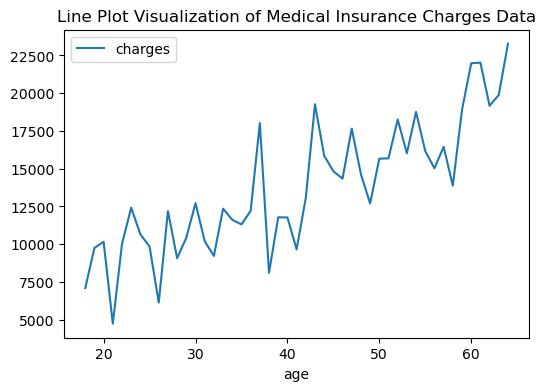

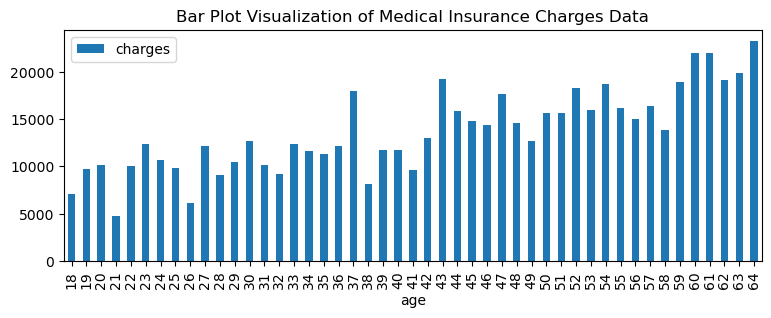

In [358]:
# Visualizing the Dataframe, with different plots. Using .pct_change() to get the percentage
# Change in data values.
print("2. Visualizations of MD Data :")
print(" NOTE : 'pct_change' refers to the ROC or velocity of the charges data.")
print("")
print("")
# Creating a line, and bar plot visualization of MD charges data
display(md_cost_age_df.plot(
    kind='line', 
    y= "charges",
    figsize=(6,4),
    title = "Line Plot Visualization of Medical Insurance Charges Data"
))
display(md_cost_age_df.plot(
    kind='bar', 
    y= "charges",
    figsize=(9,3),
    title = "Bar Plot Visualization of Medical Insurance Charges Data"
    
))

--- 

#### Step 3. Visualize the 'pct_change' in the MD Charges Data :
Visualizing the Dataframe, with different plots. Using '.pct_change' to get the percentage change in data values. Note that 'pct_change' refers to the ROC or velocity of the charges data.")

<AxesSubplot:title={'center':"Bar Plot Visualization of 'pct_change' in Medical Insurance Charges - Based on User Age"}, xlabel='age'>

<AxesSubplot:title={'center':"Histogram Plot Visualizing the Standard Deviation in Medical Insurance Charges 'pct_change' data, based on age"}, ylabel='Frequency'>

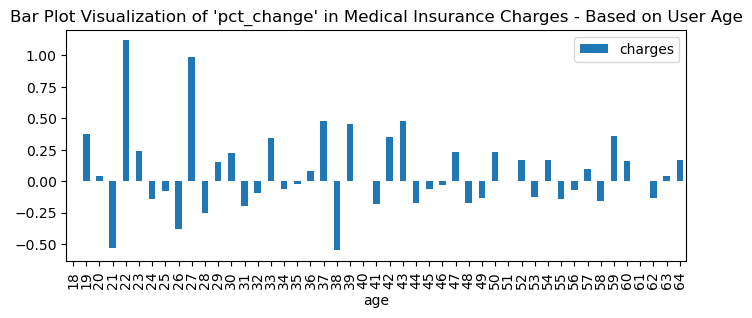

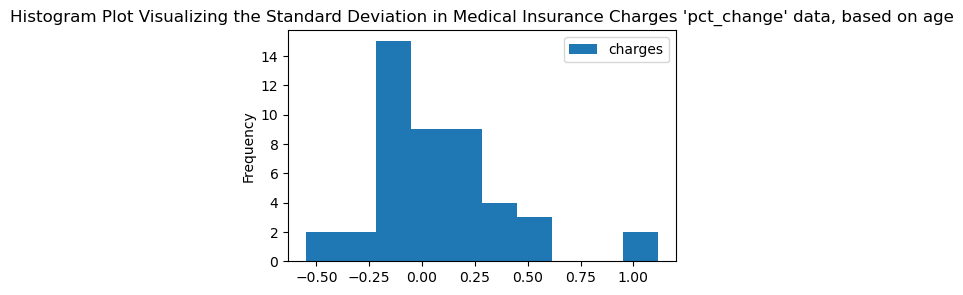

In [359]:
# Creating a bar plot visualizing the rate of change of medical insurance charges 
display(md_cost_age_df.pct_change().plot(
    kind='bar', 
    y= "charges",
    figsize=(8,3),
    title = "Bar Plot Visualization of 'pct_change' in Medical Insurance Charges - Based on User Age"
    
))

# Creating a histogram plot of the ROC data, to visualize the standard deviation of the data (a tool to help measure how accurate/correlated the data is) 
display(md_cost_age_df.pct_change().plot(
    kind='hist', 
    y= "charges",
    figsize=(5,3),
    title = "Histogram Plot Visualizing the Standard Deviation in Medical Insurance Charges 'pct_change' data, based on age"
    
))

# Part 4.5 - Visualizing the API stock Data :

#### Step 1. Visualize Closing Prices

In [360]:
## Create a visual aggregation exploring the Closing Prices by year
closing_prices_df.hvplot(
    ylabel='Close',
    xlabel='Date',
    title="Closing Prices of 'S&P Top 50' stocks").opts(
    height= 500,
    width=1000,
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [361]:
## Create a visual aggregation exploring the Daily Returns by year
daily_returns_df.hvplot(
    ylabel='Daily returns',
    xlabel='Date',
    title='Daily Returns of API stocks').opts(
    height= 500,
    width=1000,
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

There were several issues with the data that had popped up in the visualizations, large disrepancies between real prices of stocks, and their actual values, aswell as numerous other outliers and sudden 'dips' in the data.

The issue was described by a developer at Alpaca, who states that :
"The data returned by the get_barset method is not adjusted for splits or dividends. Furthermore, it’s only data reported from several major exchanges and not the broader market. It is provided free for all users with the intended use case to be debugging algorithms in paper trading.

The Polygon.io 40 data is provided is by default adjusted for splits but not dividends. It is generally very reliable. It can be fetched as split or non-split adjusted." 

As the progject has progressed significantly, we will 'cut out' these false values. 


#### Step 2. Visualize the distribution of daily returns, and cumulative returns

In [362]:
import matplotlib.pyplot as plt

# Visualize the distribution of daily returns across all stocks using a histogram plot
# Give the plot a title and adjust the figure size
daily_returns_df.hvplot.hist( 
    title="Daily Returns Histogram - API Stock Data",
    ylabel= 'Frequency',
    xlabel = 'Standard Deviation'
).opts(
    height=700,
    width=900
)

# plt.ylabel(ylabel=rot=0)

:NdOverlay   [Element]
   :Histogram   [T]   (T_count)

In [363]:
(daily_returns_df+1).cumprod().hvplot( 
    title="Cumulative Returns - 1 Dollar Invested In 50 stocks ",
    ylabel= 'Value of Investment',
    xlabel = 'Date',
).opts(
    height=450,
    width=800
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

By zooming in and visually analyzing the plot, it can be confirmed that the stocks that have historically produced the best cumulative returns (within the time-period we are analyzing) are :

    1. TSLA
    2. MSFT
    3. DHR
    4. AMZN
    5. LLY
    6. TMO
    7. ADBE
    8. NFLX
    9. MA
    10.NVDA

Cumulative returns helps us to find which investments have historically produced the greatest returns, and also identify those that result in massive losses.

In [364]:
# Each daily return value is a percentage calculation that’s expressed as a decimal. 
# To calculate the new value of an investment based on the return value, we need to add 
# one to the return value.

#### Step 3. Summarize Data, and Begin Quantitative Analysis 


As we look to find the 'top ten' stocks out of the fifty, we must look at certain paramaters. 'Best' is a subjective term, and in the case of our project, best would be the stock with the greatest potential returns, with the minimal downside risk. Therefore, we may use variance, covariance, and beta, aswell as the sharpe ratio to potentially determine which of the stocks produces optimal returns for our user.

In [365]:
daily_returns_df.describe()

,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,...,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,-0.000151,0.001567,0.001181,0.000730,-0.000063,0.001430,0.002904,0.000772,-0.001379,0.000568,...,0.000755,0.000429,0.000591,0.001205,-0.000246,0.000644,0.000946,-0.001212,0.000923,0.000103
std,0.017852,0.022815,0.021426,0.021332,0.028349,0.035717,0.043724,0.021436,0.022412,0.026100,...,0.024975,0.020055,0.022113,0.026699,0.021907,0.018593,0.020734,0.033959,0.029664,0.018518
min,-0.095921,-0.147464,-0.079770,-0.116342,-0.156000,-0.187559,-0.185778,-0.111008,-0.122248,-0.172769,...,-0.118257,-0.102833,-0.116301,-0.111375,-0.124528,-0.139424,-0.134171,-0.419486,-0.149453,-0.086677
25%,-0.006407,-0.007743,-0.008356,-0.006939,-0.010885,-0.015614,-0.013863,-0.006692,-0.009536,-0.009513,...,-0.011014,-0.008610,-0.008455,-0.013664,-0.008173,-0.008210,-0.005590,-0.007235,-0.011746,-0.006057
50%,0.000364,0.001379,0.001189,0.000809,0.000419,0.002506,0.002538,0.000797,-0.001287,0.000374,...,0.000693,0.001287,0.000670,0.000050,0.001111,0.000385,0.001512,0.001057,0.000484,0.001346
75%,0.007134,0.010381,0.010199,0.009468,0.010800,0.018271,0.020661,0.009945,0.008804,0.009698,...,0.013042,0.009404,0.010589,0.016359,0.008809,0.010503,0.007433,0.009007,0.013679,0.007589
max,0.116099,0.142268,0.094452,0.096202,0.197700,0.171564,0.198949,0.104485,0.126868,0.127989,...,0.135294,0.116947,0.151752,0.097235,0.082171,0.061207,0.136904,0.157572,0.232074,0.079211


In [366]:
# Identify the stocks with the best cumulative returns (within the selected time period)
(daily_returns_df+1).cumprod().head()
    

,BRK.B,MSFT,AMZN,GOOGL,MS,NVDA,TSLA,GOOG,XOM,UNH,...,TXN,LIN,NKE,NFLX,PM,BMY,NEE,RTX,QCOM,T
2018-11-01,1.002825,0.991667,1.042253,0.995782,1.005037,1.034530,1.020633,0.993713,1.012425,0.998393,...,1.051384,0.979029,1.023321,1.051693,1.003179,1.031460,0.988232,1.027131,1.013039,0.993807
2018-11-02,1.006284,0.993914,1.042253,0.982496,1.006351,1.019400,1.026948,0.982373,1.028489,0.998699,...,1.024022,0.965976,1.020522,1.024256,1.007721,1.002968,0.974783,1.025924,1.006996,0.994785
2018-11-05,1.053390,1.006554,1.018642,0.968045,1.003504,1.004459,1.012095,0.965935,1.024598,0.998699,...,1.030486,0.978969,1.033182,1.045265,1.016805,1.029482,0.989623,1.024475,1.009222,0.998370
2018-11-06,1.064449,1.008520,1.028035,0.980735,1.001314,1.001091,1.011087,0.980534,1.028991,1.008380,...,1.046429,1.000363,1.020389,1.030022,1.007948,1.016027,0.993971,1.030030,1.011767,1.009126
2018-11-07,1.077747,1.048216,1.098548,1.016193,1.020806,1.014040,1.032136,1.015435,1.042043,1.050813,...,1.047075,1.008340,1.039046,1.085228,1.011355,1.048476,1.006029,1.051043,1.005088,1.013690


#### Step 4. Identify Top Performing Securities 

In [367]:
year_trading_days = 252

In [368]:
# 1.
# Sort the standard deviation values using Pandas 'sort_values' function
standard_deviation_sorted = standard_deviation_df.sort_values()




In [369]:
# 2.
# Calculate the annualized standard deviation, using the standard_deviation
# from the daily_returns DataFrame multiplied by the square root (np.sqrt)
# of the number of trading days in a year (252)
annualized_standard_deviation = standard_deviation_df * np.sqrt(year_trading_days)

# Display the sorted results, in a 'top ten'
print(" Annualized Standard Deviation : Top 10 Stocks")
      
top_std = annualized_standard_deviation.sort_values().head(10)
top_std
annualized_standard_deviation


 Annualized Standard Deviation : Top 10 Stocks


BRK.B    0.283398
MSFT     0.362174
AMZN     0.340130
GOOGL    0.338635
MS       0.450023
NVDA     0.566994
TSLA     0.694095
GOOG     0.340284
XOM      0.355782
UNH      0.414326
JPM      0.403575
JNJ      0.279642
META     0.384909
V        0.360465
HD       0.370002
PG       0.272615
MA       0.411508
CVX      0.445151
MRK      0.272196
ABBV     0.340857
LLY      0.312976
BAC      0.447755
AVGO     0.465080
PEP      0.308463
PFE      0.285930
KO       0.277498
COST     0.270251
TMO      0.324963
CSCO     0.365882
WMT      0.265985
MCD      0.332193
DIS      0.384284
ABT      0.326207
WFC      0.391442
ACN      0.332473
CMCSA    0.312809
ADBE     0.408848
CRM      0.399916
DHR      0.296812
VZ       0.229512
TXN      0.396468
LIN      0.318368
NKE      0.351029
NFLX     0.423829
PM       0.347762
BMY      0.295151
NEE      0.329135
RTX      0.539082
QCOM     0.470903
T        0.293957
dtype: float64

WHAT THE STANDARD DEVIATION SHOWS US : 

Based on the annualized std information, we can deduce that these 'top ten' stocks are among the least volatile within the pool of fifty. The goal is to identify ten of the fifty stocks with the greatest returns, with the minimum downside risk. Though these are not the 'best stocks' in any way, they are among those who fluctuate from their usual values the least, meaning they are generally much less risky than their counterparts at the other end of the table. 
Less risk does not always mean a better stock, the stock with the greatest annualized std is TSLA, which has generated significant returns for investors-- mostly upside! This is why we must pair our analysis of general voltaility with a wode arrange of other metrics, to dig deeper into the stock data!

In [370]:
# To calculate the annualized average return of portfolio,
# calculate the mean of the daily return values for each stock in 'portfolio_a_b'
# and then multiply that by the number of trading days in the year
average_annual_return = daily_returns_df.mean() * year_trading_days
print(" Average Annual Return : Top 10 Stocks ")
top_annual_return = average_annual_return.sort_values().tail(10)
top_annual_return

 Average Annual Return : Top 10 Stocks 


LLY     0.282130
TMO     0.283570
MA      0.289908
AMZN    0.297606
NFLX    0.303732
ADBE    0.308356
NVDA    0.360324
DHR     0.366279
MSFT    0.394948
TSLA    0.731794
dtype: float64

By zooming in and visually analyzing the 'cumulative returns' plot (can be found in step 2. of part 4.5), it can be confirmed that the stocks that have historically produced the best cumulative returns (within the time-period we are analyzing) are :

    1. TSLA
    2. MSFT
    3. DHR
    4. AMZN
    5. LLY
    6. TMO
    7. ADBE
    8. NFLX
    9. MA
    10.NVDA

In [371]:
# Calculate Sharpe Ratio by dividing the average annual return by the standard deviation
sharpe_ratios = average_annual_return / annualized_standard_deviation
# Display the 'Top 10' stocks, in terms of 'Sharpe Ratio'
print(" Sharpe Ratio : Top 10 Stocks")
top_sharpe_ratio = sharpe_ratios.sort_values().tail(10)
top_sharpe_ratio

 Sharpe Ratio : Top 10 Stocks


NEE     0.724163
ADBE    0.754206
PG      0.813538
COST    0.823690
TMO     0.872623
AMZN    0.874977
LLY     0.901444
TSLA    1.054313
MSFT    1.090493
DHR     1.234046
dtype: float64

In [372]:
# Turning our curated lists into .csv files to be integrated into
# The CLI.

# CSV for Top Sharpe ratio performers:
tsr_filepath = Path('Resources/top_sharpe_ratios.csv')
tsr_filepath.parent.mkdir(parents=True, exist_ok=True)  
top_sharpe_ratio.to_csv(tsr_filepath)


# CSV for Top Annual Return performers:
tar_filepath = Path('Resources/top_annual_returns.csv')
tar_filepath.parent.mkdir(parents=True, exist_ok=True)  
top_annual_return.to_csv(tar_filepath)


# CSV for Lowest Risk stocks:
tstd_filepath = Path('Resources/top_std.csv')
tstd_filepath.parent.mkdir(parents=True, exist_ok=True)  
top_std.to_csv(tstd_filepath) 

list(top_std.head().keys())
list(top_sharpe_ratio.tail().keys())
list(top_sharpe_ratio.tail().keys())
top_sharpe_ratio

NEE     0.724163
ADBE    0.754206
PG      0.813538
COST    0.823690
TMO     0.872623
AMZN    0.874977
LLY     0.901444
TSLA    1.054313
MSFT    1.090493
DHR     1.234046
dtype: float64

We have now identified those stocks which will likely produce the greatest returns with a minimum of risk required-- though many of these stocks remain volatile, there still remaind potential for returns! The Sharpe ratio allows us to identify those stocks affected by all types of volatility, upward and downward-- meaning that a fine balance may arise within the portfolio. The above 'top ten' stocks with sharpe ratio are solid options, with many of them in the top 10 in regards to cumulative returns, average annual returns.

Depending on Customers risk-tolerance, different portfolio's may work best:

1. Low Risk : 5 Stocks w. lowest std, & 5 with the best sharpe ratios
2. Medium Risk : 10 stocks with the best sharpe_ratios
3. High risk : 5 stocks with the best sharpe ratios, and 5 with the best average annual returns
4. Ultra high-risk : 10 stocks with the highest average annual returns, only


# Part 5. Taking in the user information and input :

#### Step 1. Create a function to recieve the applicant information :

In [373]:

def get_applicant_info():
    
    """Prompt dialog to get the applicant's MD insurance information.

    Returns:
        Returns the applicant's MD insurance information.
    """

    md_charges = float(input("What are your annual medical insurance costs?"))
    age = int(input("What's your current age?"))
    initial_investment = float(input("How much will your initial investment in our financial product (the portfolio) be?"))
    risk_assesment = str(input(("In general, what is your risk-tolerance ? (your answer will affect the portfolio selection, so please answer carefully. Also note that with greater risk, comes greater potential returns - choices= 'Low Risk", "Medium Risk", "High Risk", "Ultra-High Risk']")))
    md_charges = float(md_charges)
    age = int(age)
    initial_investment = float(initial_investment)
    risk_assesment = str(risk_assesment)
    return md_charges, age, initial_investment, risk_assesment

list(top_annual_return)


[0.2821304729122908,
 0.2835701164709264,
 0.2899084524447249,
 0.2976064247264079,
 0.30373182839738666,
 0.3083560288421784,
 0.36032440552100387,
 0.3662794575196327,
 0.3949478447497457,
 0.7317936133077279]

#### Step 2. Create a function to create a portfolio, based on the risk assesment (unweighted) :



In [412]:

# Note - there was an attempt to create a CLI in a seperate folder with cleaner functionality, and to completely design the application
# around providing the user with the service, but due to time constraints (and a failure to get any real progress after trying numerous different strategies), 
# The CLI will be pushed to another project.

# Also - as portfolios may have stocks more than once in the portfolio, this will simply mean double weight inherently.
portfolio = pd.DataFrame()
def create_unweighted_portfolio():
    # Get the applicant's information
    md_charges, age, initial_investment, risk_assesment = get_applicant_info()
    if risk_assesment == str("Low Risk"):
        portfolio = list(top_std.keys())
        print(f" Based on your selection, we have currated an unweighted portfolio with the following stocks : {portfolio}")
        risk = 1
    elif risk_assesment == str("Medium Risk"):
        portfolio = list(top_sharpe_ratio.keys())
        print(f" Based on your selection, we have currated an unweighted portfolio with the following stocks : {portfolio}")
        risk = 2
    elif risk_assesment == str("High Risk"):
        portfolio =  list(top_annual_return.keys())
        print(f" Based on your selection, we have currated an unweighted  portfolio with the following stocks : {portfolio}")
        risk = 3
    elif risk_assesment == str("Ultra-High Risk"):
        portfolio = list(top_annual_return[8:10].keys())
        print(f" Based on your selection, we have currated an unweighted  portfolio with the following stocks : {portfolio}")
        risk = 4
    else :
        print("Invalid Input")
    return portfolio

create_unweighted_portfolio()

portfolio.head()



 Based on your selection, we have currated an unweighted portfolio with the following stocks : ['VZ', 'WMT', 'COST', 'MRK', 'PG', 'KO', 'JNJ', 'BRK.B', 'PFE', 'T']


""


In [413]:
# Create and fill an empty closing_prices_df for the stock data. 
closing_prices_df = pd.DataFrame()

# Using a for loop, for every ticker in the tickers list, 
# Select the close price for each ticker in the prices_df Dataframe
# That will be set equal to closing_prices_df for the same ticker value
for ticker in tickers:
    closing_prices_df[ticker] = prices_df[ticker]["close"]

# For the new closing_prices_df DataFrame, keep only the date component
closing_prices_df.index = closing_prices_df.index.date

#Remove missing values
closing_prices_df = closing_prices_df.dropna()

#### Step 3. Switch to Log Returns

In order to do this, we will re-run the API with only our 'chosen' stocks based on the risk assesment.

(P.S) : I had learned this from 'Prateek Singh' who was actually referenced by Mr. Firas in his GitLab, on the monte carlo sim tools package. I had went to his github to try and learn about how I could create my own 'portfolio optimizer' and remember how it's done!

As for 'why we use log returns ', this article was te reference : https://quantivity.wordpress.com/2011/02/21/why-log-returns/

 Based on your selection, we have currated an unweighted portfolio with the following stocks : ['VZ', 'WMT', 'COST', 'MRK', 'PG', 'KO', 'JNJ', 'BRK.B', 'PFE', 'T']
1. Create a new DataFrame, based on the user risk assesment :


,VZ,WMT,COST,MRK,PG,KO,JNJ,BRK.B,PFE,T
timestamp,,,,,,,,,,
2017-05-01 04:00:00+00:00,45.88,75.23,177.86,62.38,87.09,43.22,123.34,165.44,33.78,39.10
2017-05-02 04:00:00+00:00,45.91,75.52,178.59,62.70,86.22,43.39,123.70,166.05,33.61,38.95
2017-05-03 04:00:00+00:00,46.15,75.76,179.82,63.63,86.43,43.32,123.33,166.73,33.47,38.40
2017-05-04 04:00:00+00:00,45.88,76.34,182.45,63.38,86.45,43.66,123.95,166.34,33.45,38.01
2017-05-05 04:00:00+00:00,46.69,76.50,180.20,63.97,86.50,43.69,123.51,166.55,33.48,38.56
...,...,...,...,...,...,...,...,...,...,...
2020-04-27 04:00:00+00:00,57.81,128.30,308.78,83.98,117.45,46.78,154.29,187.46,38.33,30.54
2020-04-28 04:00:00+00:00,57.83,128.00,304.95,81.18,116.89,46.74,151.39,187.12,37.91,30.65
2020-04-29 04:00:00+00:00,58.12,123.60,307.09,80.77,117.08,47.12,150.24,189.61,38.12,31.43


2. Find the average daily returns of the stocks in our portfolio :


VZ       0.000372
WMT      0.000768
COST     0.000812
MRK      0.000396
PG       0.000487
KO       0.000163
JNJ      0.000347
BRK.B    0.000240
PFE      0.000249
T       -0.000222
dtype: float64

3. Finding the correlation in daily returns between the stocks in our portfolio :


,VZ,WMT,COST,MRK,PG,KO,JNJ,BRK.B,PFE,T
VZ,1.000000,0.458188,0.490570,0.487997,0.553076,0.531019,0.501085,0.489212,0.496490,0.664610
WMT,0.458188,1.000000,0.613253,0.376603,0.535590,0.415905,0.465816,0.449904,0.475859,0.411357
COST,0.490570,0.613253,1.000000,0.444913,0.496645,0.459583,0.535283,0.551738,0.492798,0.459909
MRK,0.487997,0.376603,0.444913,1.000000,0.491498,0.552291,0.603751,0.541687,0.626996,0.461215
PG,0.553076,0.535590,0.496645,0.491498,1.000000,0.643500,0.604714,0.526683,0.546375,0.512248
KO,0.531019,0.415905,0.459583,0.552291,0.643500,1.000000,0.572787,0.580644,0.575586,0.542297
JNJ,0.501085,0.465816,0.535283,0.603751,0.604714,0.572787,1.000000,0.585276,0.652190,0.495932
BRK.B,0.489212,0.449904,0.551738,0.541687,0.526683,0.580644,0.585276,1.000000,0.615569,0.584652
PFE,0.496490,0.475859,0.492798,0.626996,0.546375,0.575586,0.652190,0.615569,1.000000,0.517293
T,0.664610,0.411357,0.459909,0.461215,0.512248,0.542297,0.495932,0.584652,0.517293,1.000000


<AxesSubplot:title={'center':'Historical Movements of Portfolio Stocks'}, xlabel='Date', ylabel='Logarithmic Returns'>

4. Visualizing the portfolios historical daily returns visually, aswell as stocks historic volatility :


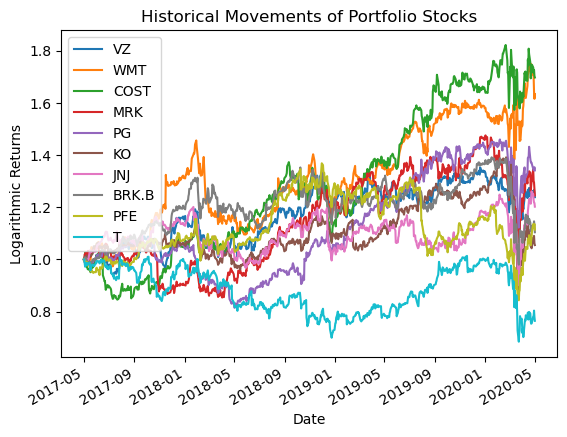

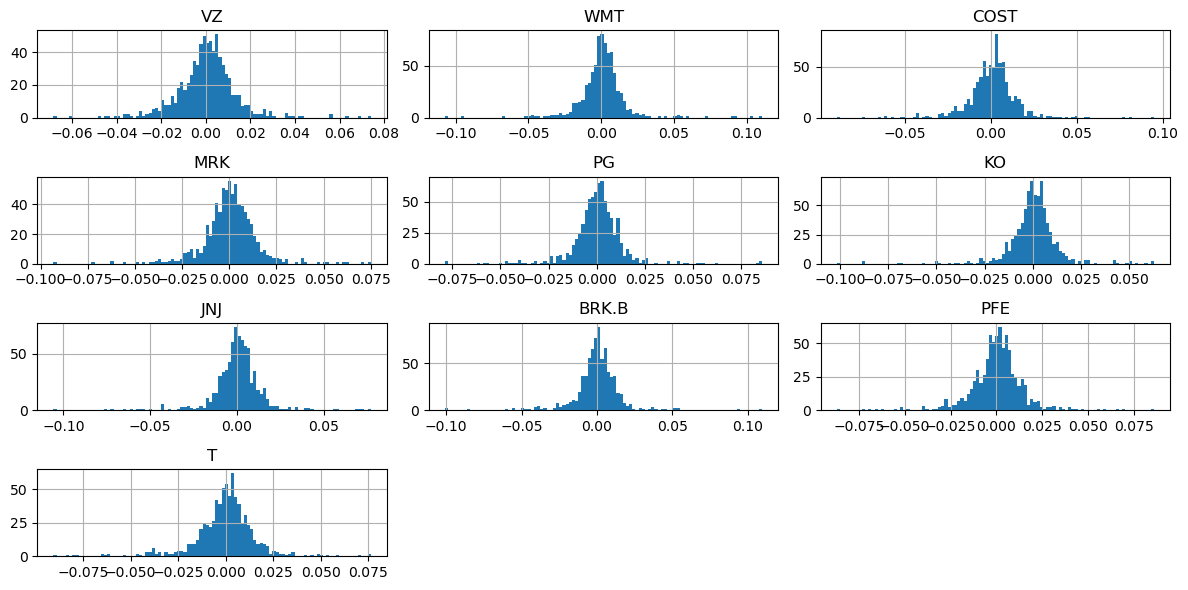

In [418]:
# Here, we run through and do what we had done with the entire portfolio, specifically with our much
# smaller portfolios, now, we will be able to look more deeply into the data and get ready
# for optimization :

def analyze_and_log() :
    updated_prices_df = pd.DataFrame()
    new_closing_prices_df = pd.DataFrame()
    stock_daily_ret = pd.DataFrame()
    portfolio = create_unweighted_portfolio()
    tickers = portfolio
    new_df = prices_df[tickers]
    for ticker in tickers:
        new_closing_prices_df[ticker] = new_df[ticker]["close"]
    print("1. Create a new DataFrame, based on the user risk assesment :")
    display(new_closing_prices_df)
    mean_daily_ret = new_closing_prices_df.pct_change(1).mean()
    print("2. Find the average daily returns of the stocks in our portfolio :")
    display(mean_daily_ret)
    print("3. Finding the correlation in daily returns between the stocks in our portfolio :")
    display(new_closing_prices_df.pct_change(1).corr())
    stock_normed = new_closing_prices_df/new_closing_prices_df.iloc[0]
    display(stock_normed.plot(title='Historical Movements of Portfolio Stocks', xlabel='Date',ylabel='Logarithmic Returns'))
    stock_daily_ret = new_closing_prices_df.pct_change(1)
    log_ret = np.log(new_closing_prices_df/new_closing_prices_df.shift(1))
    print("4. Visualizing the portfolios historical daily returns visually with a line plot, aswell as stocks historic volatility with a histogram plot:")
    log_ret.hist(bins=100,figsize=(12,6))
    plt.tight_layout()
    return new_closing_prices_df, log_ret

    


analyze_and_log()

####  the Visualizations?

To understand visually and numerically how different risk assesment results might affect the overall expected returns and volatility of the stock, so that the user becomes familiar with the potential risks and rewards that come with our different portfolio options. 


# Part 5. Working with Data - Finding the Optimal Portfolio Weight.


Here we approach the end of the project! As I had to cram, and was learning from his code anyways, I have continued to use Prateek Kumar's code to help me in completing the project. It fits my use-case, and as in the real world, we as developers do share and add on apon one anothers data. 

Step 1. Single Run for Random Allocation

 Based on your selection, we have currated an unweighted  portfolio with the following stocks : ['MSFT', 'TSLA']
1. Create a new DataFrame, based on the user risk assesment :


,MSFT,TSLA
timestamp,,
2017-05-01 04:00:00+00:00,69.410,322.83
2017-05-02 04:00:00+00:00,69.300,318.89
2017-05-03 04:00:00+00:00,69.080,311.02
2017-05-04 04:00:00+00:00,68.810,295.46
2017-05-05 04:00:00+00:00,69.000,308.35
...,...,...
2020-04-27 04:00:00+00:00,174.050,798.75
2020-04-28 04:00:00+00:00,169.810,769.12
2020-04-29 04:00:00+00:00,177.430,800.51


2. Find the average daily returns of the stocks in our portfolio :


MSFT    0.001860
TSLA    0.001753
dtype: float64

3. Finding the correlation in daily returns between the stocks in our portfolio :


,MSFT,TSLA
MSFT,1.00000,0.21258
TSLA,0.21258,1.00000


<AxesSubplot:title={'center':'Historical Movements of Portfolio Stocks'}, xlabel='Date', ylabel='Logarithmic Returns'>

4. Visualizing the portfolios historical daily returns visually, aswell as stocks historic volatility :


None

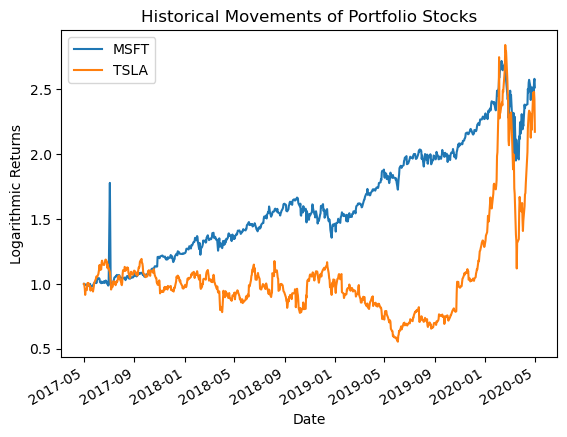

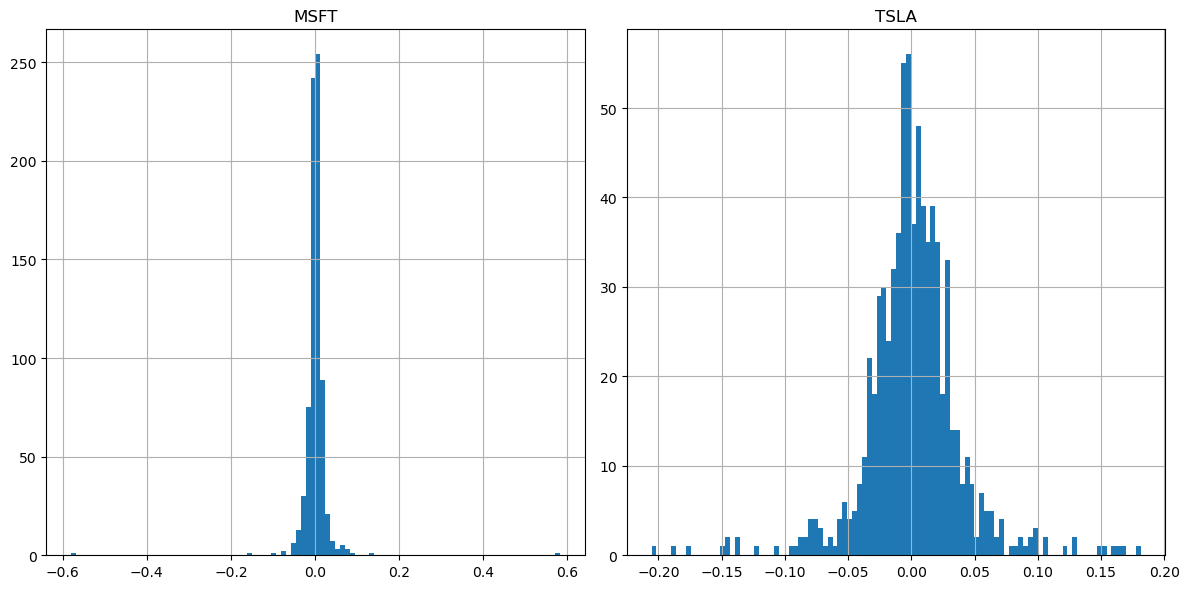

In [432]:

def single_run_alloc(df) :

    # Set seed (optional)
    np.random.seed(101)

    # Stock Columns
    print('Stocks')
    print(df.columns)
    print('\n')

    # Create Random Weights
    print('Creating Random Weights')
    weights = np.array(np.random.random(4))
    print(weights)
    print('\n')

    # Rebalance Weights
    print('Rebalance to sum to 1.0')
    weights = weights / np.sum(weights)
    print(weights)
    print('\n')

    # Expected Return
    print('Expected Portfolio Return')
    exp_ret = np.sum(log_ret.mean() * weights) *252
    print(exp_ret)
    print('\n')

    # Expected Variance
    print('Expected Volatility')
    exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    print(exp_vol)
    print('\n')

    # Sharpe Ratio
    SR = exp_ret/exp_vol
    print('Sharpe Ratio')
    print(SR)


def test() :
    new_closing_prices_df = analyze_and_log()
    display(new_closing_prices_df)

test()

Visualizations lets us understand the range of outcome the user
will likely face when choosing to purchase our financial product. The goal will be to maximize long-term stability and growth, with low volatility. This has ben made possible by screening our stocks

In [433]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram - 
MC_sim_dist_plot = MC_thirty_year.plot_distribution()

print("The histogram predictive plot has shown that")

NameError: name 'MC_thirty_year' is not defined

## Analyzing the Portfolio Stocks, Individually.

In [ ]:
print(" CALCULATION OF RISK UNDER ONE (1) STANDARD DEVIATION : ")
print("  ")


n = 1 
for ticker in tickers :
    ticker = str(input(
    mean = daily_returns_df[ticker].mean()
    std = daily_returns_df[ticker].std() 
    daily_return_probability_plus = (mean + std) * 100
    daily_return_probability_minus = (mean - std) * 100
    print(f"{n}.({ticker}) :  A 95% probability exists that the daily value of {ticker} will likely be the mean ({mean}) plus or minus two standard deviations ({std})")
    print("-------")
    print(f"   that gives us a range of : {daily_return_probability_minus}%")
    print(f"   to : +{daily_return_probability_plus}%")
    nf_lower_bound_return = mean - (1.96 * std)
    nf_upper_bound_return = mean + (1.96 * std)
    nn_lower_bound_return = mean - (2.576 * std)
    nn_upper_bound_return = mean + (2.576 * std)
    print("-------")
    print(f" From the analysis of the {ticker} historical return data, with a 95% confidence interval, we can expect our daily return value to fall between {nf_lower_bound_return*100}% and +{nf_upper_bound_return*100}% ")    
    print("-------")
    rec_value = closing_prices_df[ticker].tail(1)
    lower_bound_price = rec_value.values * (1 - nf_lower_bound_return)
    print(f"            The lower bound of the expected price for the next day is ${lower_bound_price} We get that from the following equation: ")
    print (f"           {closing_prices_df[ticker].tail(1).values} * 1 - {nf_lower_bound_return} ") 
    upper_bound_price = rec_value.values * (1 + nf_upper_bound_return)
    print(f"            The upper bound of the expected price for the next day is ${upper_bound_price} We get that from the following equation: ")
    print(f"            {closing_prices_df[ticker].tail(1).values} * 1 + {nf_lower_bound_return} ") 
    print(f"            {ticker}")
    print("")
    print("")
    n = n + 1

In [ ]:
print(" CALCULATION OF RISK UNDER THREE (3) STANDARD DEVIATIONS : ")
print("  ")

n = 1 
for ticker in tickers :  
    mean = daily_returns_df[ticker].mean()
    std = daily_returns_df[ticker].std() * 3
    daily_return_probability_plus = (mean + std) * 100
    daily_return_probability_minus = (mean - std) * 100
    print(f"{n}.({ticker}) :  For a 99.7% probability exists that the daily value of {ticker} will likely be the mean ({mean}) plus or minus two standard deviations ({std})")
    print(f"   that gives us a range of : {daily_return_probability_minus}%")
    print(f"   to : +{daily_return_probability_plus}%")
    print("---------------------")
    down_tail_percentage = (mean - ( std)) * 100
    print(f"The downside tail-percentage of {ticker} is : {down_tail_percentage}%")
    up_tail_percentage = (mean + ( std)) * 100
    print(f"The upside tail-percentage of {ticker} is : +{up_tail_percentage}%")
    print(f"   {ticker}")
    print("")
    print("")
    n = n + 1

In [ ]:
daily_returns_df.plot(kind='hist'
                     )

The (above) visualization will support our finding that the standard deviation of our portfolio is within an adequate range of values-- showing relatively low volatility. 

In [ ]:
initial_investment = 10000
ci_lower_ten_cumulative_return = MC_thirty_summary_statistics[8] * initial_investment
ci_upper_ten_cumulative_return = MC_thirty_summary_statistics[9] * initial_investment

# Print the result of your calculations
print(f"There is a 95% chance that an initial investment of $ {initial_investment} in the portfolio"
    f" over the next 30 years will end within in the range of"
    f" ${ci_lower_ten_cumulative_return :2f} and ${ci_upper_ten_cumulative_return :2f}.")



## Creating a Monte Carlo Simulation to Calculate Optimal Weight Distribution

In [ ]:
from io import BytesIO

import numpy as np
import numba as nb
import pandas as pd
import holoviews as hv
import panel as pn
from pathlib import Path

from scipy.optimize import minimize


In [ ]:
# from modules.questions import get_applicant_info
# md.random_allocation(prices_df,4)

NameError: global name 'unsafe_empty_inferred' is not defined

In [ ]:
# Finding the cumulative product, by repeating the previous steps 
# and treating the md insurance data as an asset.
weighted_returns = (weights * md_cost_age_df_change)

port_md_ret = weighted_returns.sum(axis=1)

cumulative_md_ret = (port_ret + 1).cumprod()

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_ret)
ax1.set_xlabel('Date')
ax1.set_ylabel("MD Cumulative Returns")
ax1.set_title("MD costs based on current costs Cumulative Returns")
plt.show();

age
18         NaN
19    0.375615
20    0.042244
21   -0.534389
22    1.116691
23    0.240378
24   -0.142659
25   -0.076038
26   -0.376540
27    0.986477
28   -0.255691
29    0.150065
30    0.219455
31   -0.198295
32   -0.095781
33    0.339602
34   -0.059750
35   -0.026378
36    0.079356
37    0.476500
38   -0.550346
39    0.453613
40   -0.000509
41   -0.179958
42    0.352950
43    0.475172
44   -0.176874
45   -0.064895
46   -0.032879
47    0.230879
48   -0.171151
49   -0.132342
50    0.233695
51    0.001229
52    0.164135
53   -0.122442
54    0.170877
55   -0.138284
56   -0.070465
57    0.094617
58   -0.156152
59    0.361479
60    0.163186
61    0.002049
62   -0.129883
63    0.037630
64    0.170507
Name: charges, dtype: float64